In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")
train.head()

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


# # Create a function to convert a date object column into 3 numeric columns

In [98]:
def to_date (dataset,date_column):
    dataset[date_column] = pd.to_datetime(dataset[date_column])
    dataset['Day'] = dataset[date_column].dt.day
    dataset['Month'] = dataset[date_column].dt.month
    dataset['Year'] = dataset[date_column].dt.year
    dataset = dataset.drop(columns = date_column)
to_date(train,'date')
to_date(test,'date')

In [99]:
for col in train.columns.tolist():
    print(train[col].value_counts())
    print("=="*30)

id
0         1
153494    1
153412    1
153413    1
153414    1
         ..
76714     1
76715     1
76716     1
76717     1
230129    1
Name: count, Length: 230130, dtype: int64
date
2010-01-01    90
2014-09-05    90
2014-08-29    90
2014-08-30    90
2014-08-31    90
              ..
2012-05-03    90
2012-05-04    90
2012-05-05    90
2012-05-06    90
2016-12-31    90
Name: count, Length: 2557, dtype: int64
country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64
store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64
product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64
num_sold
5.0       1947
6.0       1703
16.0      1434
7.0       1382
15.0      1365
          ... 
3621.0       1
3683.0       1
4139.0       1
334

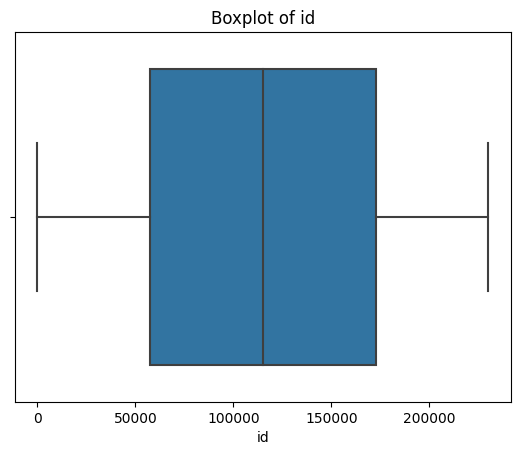

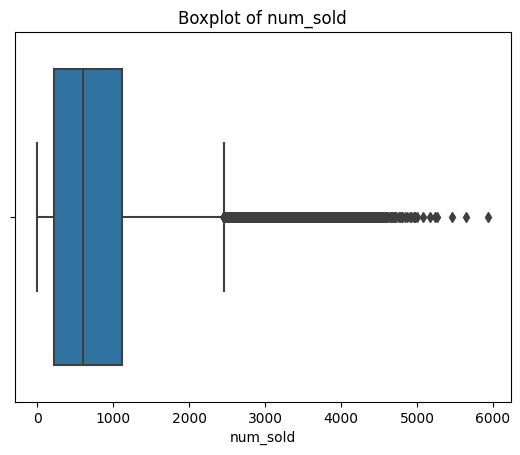

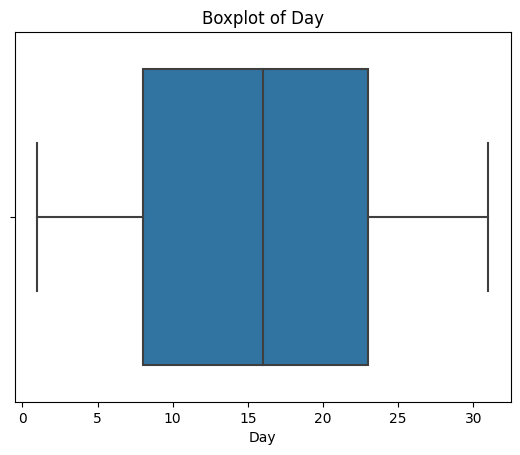

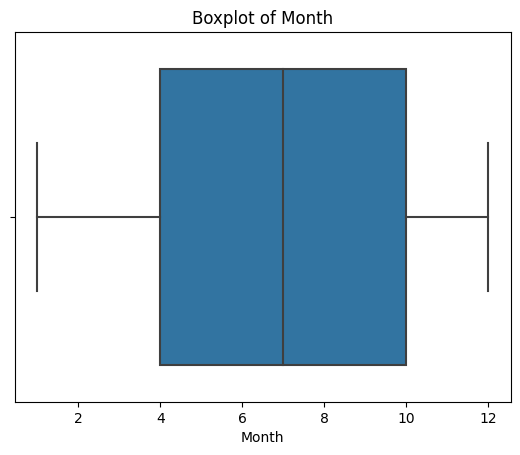

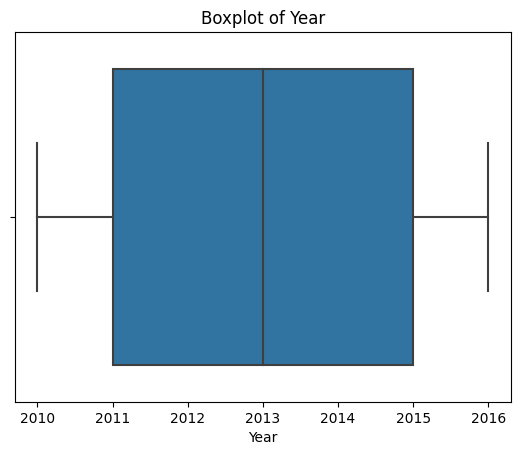

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

train1 = pd.get_dummies(train)
numeric_columns = train1.select_dtypes(include=['number']).columns.tolist()

for col in numeric_columns:
    sns.boxplot(x=train1[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [101]:
#Test first
train1 = train1[(train1['num_sold'] < 2300) | (train1['num_sold'].isna())]

def handle_null_values(data, column):
    non_null_data = data.dropna()
    null_data = data[data[column].isna()]
    return non_null_data, null_data
non_null_data, null_data = handle_null_values(train1, 'num_sold')

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet,Ridge,SGDRegressor,BayesianRidge,TheilSenRegressor,RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

In [103]:
non_null_data = non_null_data.drop(columns=['id','date'])
x_nnd = non_null_data.drop(columns = ['num_sold'])
y_nnd = non_null_data['num_sold']
x_nnd_train, x_nnd_test, y_nnd_train, y_nnd_test = train_test_split(x_nnd,y_nnd,test_size=0.2,random_state=16)

In [104]:
def model_list(models, random_state_num, x_train, x_test, y_train, y_test):
    r2_score_dict = {}
    for model_class in models:
        model = model_class(random_state=random_state_num)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        model_name = model_class.__name__
        
        r2_score_dict[model_name] = r2_score(y_test, y_pred)
    
    return r2_score_dict

models = [DecisionTreeRegressor, GradientBoostingRegressor, RandomForestRegressor, XGBRegressor, LGBMRegressor]
r2_scores = model_list(models, 16, x_nnd_train, x_nnd_test, y_nnd_train, y_nnd_test)

print("R2 Scores for different models:")
for model_name, score in r2_scores.items():
    print(f"{model_name}: {score:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 170573, number of used features: 17
[LightGBM] [Info] Start training from score 672.055724
R2 Scores for different models:
DecisionTreeRegressor: 0.9583
GradientBoostingRegressor: 0.9536
RandomForestRegressor: 0.9740
XGBRegressor: 0.9796
LGBMRegressor: 0.9760


In [105]:
def linear_model_list(models, x_train, x_test, y_train, y_test):
    r2_score_dict = {}
    for model_class in models:
        model = model_class()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        model_name = model_class.__name__
        
        r2_score_dict[model_name] = r2_score(y_test, y_pred)
    
    return r2_score_dict

models = [LinearRegression, Lasso, ElasticNet,Ridge,SGDRegressor,BayesianRidge,TheilSenRegressor,RANSACRegressor]
r2_scores = linear_model_list(models, x_nnd_train, x_nnd_test, y_nnd_train, y_nnd_test)

print("R2 Scores for different models:")
for model_name, score in r2_scores.items():
    print(f"{model_name}: {score:.4f}")

R2 Scores for different models:
LinearRegression: 0.8156
Lasso: 0.8154
ElasticNet: 0.3428
Ridge: 0.8156
SGDRegressor: -267132857390889789554688.0000
BayesianRidge: 0.8156
TheilSenRegressor: 0.7983
RANSACRegressor: 0.8024


In [106]:
train1.isnull().sum()

id                               0
date                             0
num_sold                      8871
Day                              0
Month                            0
Year                             0
country_Canada                   0
country_Finland                  0
country_Italy                    0
country_Kenya                    0
country_Norway                   0
country_Singapore                0
store_Discount Stickers          0
store_Premium Sticker Mart       0
store_Stickers for Less          0
product_Holographic Goose        0
product_Kaggle                   0
product_Kaggle Tiers             0
product_Kerneler                 0
product_Kerneler Dark Mode       0
dtype: int64

In [122]:
x_null_data = null_data.drop(columns = ['id','date','num_sold'])
pred_model = LinearRegression().fit(x_nnd_train, y_nnd_train)
imputer = pred_model.predict(x_null_data)
imputer = imputer.tolist()
imputer = [abs(x) for x in imputer]

In [127]:
nan_indices = train1[train1['num_sold'].isna()].index
# Replace NaNs with the values from the array
train1.loc[nan_indices, 'num_sold'] = imputer
train1.info()

ValueError: Must have equal len keys and value when setting with an iterable

In [128]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222088 entries, 0 to 230129
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          222088 non-null  int64         
 1   date                        222088 non-null  datetime64[ns]
 2   num_sold                    222088 non-null  float64       
 3   Day                         222088 non-null  int32         
 4   Month                       222088 non-null  int32         
 5   Year                        222088 non-null  int32         
 6   country_Canada              222088 non-null  bool          
 7   country_Finland             222088 non-null  bool          
 8   country_Italy               222088 non-null  bool          
 9   country_Kenya               222088 non-null  bool          
 10  country_Norway              222088 non-null  bool          
 11  country_Singapore           222088 non-null 

In [129]:
x_train1 = train1.drop(columns = ['id','date','num_sold'])
y_train1 = train1['num_sold']
x_train1_train, x_train1_test, y_train1_train, y_train1_test = train_test_split(x_train1,y_train1,test_size = 0.25, random_state=16)
models = [DecisionTreeRegressor, GradientBoostingRegressor, RandomForestRegressor, XGBRegressor, LGBMRegressor]
r2_scores = model_list(models, 16, x_train1_train, x_train1_test, y_train1_train, y_train1_test)

print("R2 Scores for different models:")
for model_name, score in r2_scores.items():
    print(f"{model_name}: {score:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 166566, number of used features: 17
[LightGBM] [Info] Start training from score 665.012131
R2 Scores for different models:
DecisionTreeRegressor: 0.9543
GradientBoostingRegressor: 0.9488
RandomForestRegressor: 0.9721
XGBRegressor: 0.9779
LGBMRegressor: 0.9743
